### PMIP4 analysis and producing figures for EOS 440 final project 

#### Intake data and filter activity, experiment, variable

In [1]:
# imports should run with given env

import intake
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
import pandas as pd
import numpy as np
import xesmf as xe

In [2]:
# import esm data from server

import intake_esm
url ="https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"

In [3]:
# intake data as xarray

cat = intake.open_esm_datastore(url)

### Seperate out CMIP piControl experiment and the PMIP experiments.

In [4]:
cat_cmip = cat.search(activity_id = 'CMIP')
cat_picontrol = cat_cmip.search(experiment_id = 'piControl', variable_id = ['pr', 'ts'])

In [5]:

cat_cmip.df['experiment_id'].unique()

array(['piControl', 'historical', 'amip', 'abrupt-4xCO2', '1pctCO2',
       'esm-piControl', 'esm-hist', 'piControl-spinup', 'hist-GHG',
       'hist-nat', 'esm-piControl-spinup', 'historical-cmip5',
       'piControl-cmip5', 'historical-ext'], dtype=object)

Activity ID for PMIP4 -- experiments used. Lig127k and MidHolocene are taken as the two interglacial datasets, comapred to eachother and the present day Past1000 data.

In [6]:
# filter to PMIP and show experiments 

cat_pmip = cat.search(activity_id = 'PMIP')
cat_pmip.df['experiment_id'].unique()

array(['midHolocene', 'lig127k', 'lgm', 'past1000'], dtype=object)

In [7]:
# seperate each experiment out

cat_holo = cat_pmip.search(experiment_id = 'midHolocene', variable_id = ['pr', 'ts'])
cat_lig = cat_pmip.search(experiment_id = 'lig127k', variable_id = ['pr', 'ts'])


In [8]:
cat_holo

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,3
table_id,1
variable_id,2
grid_label,1
zstore,6
dcpp_init_year,0


In [9]:
# check the ensemble member numbers for each dataset in order to understand limitations of comparison

print(cat_holo.df['member_id'].unique())
print(cat_lig.df['member_id'].unique())
print(cat_picontrol.df['member_id'].unique())

['r1i1p1f3' 'r1i1p1f2' 'r1i1p1f1']
['r1i1p1f1']
['r1i1p1f1' 'r1i1p1f2' 'r1i2p1f1' 'r1i1p2f1' 'r1i1p5f1' 'r2i1p1f1'
 'r102i1p1f1' 'r101i1p1f1' 'r3i1p1f1' 'r1i1p1f3' 'r1i1p3f1' 'r1i1p2f2'
 'r1i1p3f2']


*Based on the above, we have limited ensemble members for comparison, and need to keep this in mind when discussing results*

#### Convert to dictionary dataset to begin plotting

In [10]:
dset_picont = cat_picontrol.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True},
    skip_on_error=True
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [11]:
# check which keys it actually loads (skip - on - error)
#dset_picont.keys()

In [12]:
dset_holo = cat_holo.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [13]:
dset_lig = cat_lig.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [14]:
dset_lig.keys()

dict_keys(['PMIP.IPSL.IPSL-CM6A-LR.lig127k.Amon.gr'])

In [15]:
dset_holo

{'PMIP.IPSL.IPSL-CM6A-LR.midHolocene.Amon.gr': <xarray.Dataset>
 Dimensions:         (lat: 143, lon: 144, time: 6600, dcpp_init_year: 1,
                      member_id: 3, axis_nbounds: 2)
 Coordinates:
   * lat             (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
   * lon             (lon) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
   * time            (time) object 1850-01-16 12:00:00 ... 2399-12-16 12:00:00
   * dcpp_init_year  (dcpp_init_year) float64 nan
   * member_id       (member_id) object 'r1i1p1f1' 'r1i1p1f2' 'r1i1p1f3'
     time_bounds     (time, axis_nbounds) object dask.array<chunksize=(2400, 2), meta=np.ndarray>
 Dimensions without coordinates: axis_nbounds
 Data variables:
     pr              (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 600, 143, 144), meta=np.ndarray>
     ts              (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 800, 143, 144), meta=np.ndarray>
 Att

In [161]:
# option to un-comment (one at a time) and inspect parameters:

#dset_holo
#dset_lig
#dset_picont


In [163]:
# extracting dataset to be usable

ds_holo1 = dset_holo['PMIP.IPSL.IPSL-CM6A-LR.midHolocene.Amon.gr']
ds_lig1 = dset_lig['PMIP.IPSL.IPSL-CM6A-LR.lig127k.Amon.gr']
ds_now = dset_picont['CMIP.IPSL.IPSL-CM5A2-INCA.piControl.Amon.gr']


In [141]:
ds_now

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 12, lat: 143,
                     lon: 144, bnds: 2)
Coordinates:
  * time            (time) object 1850-01-16 12:00:00 ... 1850-12-16 12:00:00
    time_bnds       (time, bnds) object dask.array<chunksize=(12, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f2' 'r1i1p2f2' 'r1i1p3f2'
  * dcpp_init_year  (dcpp_init_year) float64 nan
  * lat             (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon             (lon) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    pr              (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 6, 143, 144), meta=np.ndarray>
    ts              (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 6, 143, 144), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            -127835.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20210125
    intake_esm_attrs:_data_format_:   zarr
    status:                           2021-07-06;created; by gcs.cmip6.ldeo@g...
    intake_esm_dataset_key:           CMIP.MIROC.MIROC-ES2H.piControl.Amon.gn
    regrid_method:                    conservative

### Check if regridding is needed to compare plots

In [164]:
print(ds_holo1['lat'].shape, ds_now['lat'].shape)
print(ds_holo1['lon'].shape, ds_now['lon'].shape)

# yes!

(143,) (96,)
(144,) (96,)


In [165]:
# regridding!
ds_output = xr.Dataset(
    {
        'lat': (['lat'], ds_now.lat.to_numpy(), {'units': 'degrees_north'}),
        'lon': (['lon'], ds_now.lon.to_numpy(), {'units': 'degrees_east'}),
    }
)
#ds_output

In [166]:
regridder = xe.Regridder(ds_holo1, ds_output, "conservative")
regridder  

/Users/kellybaker/anaconda3/envs/envir_440/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/Users/kellybaker/anaconda3/envs/envir_440/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_143x144_96x96.nc 
Reuse pre-computed weights? False 
Input grid shape:           (143, 144) 
Output grid shape:          (96, 96) 
Periodic in longitude?      False

In [169]:
ds_holo = regridder(ds_holo1, keep_attrs=True)
ds_lig = regridder(ds_lig1, keep_attrs=True)

In [170]:
print(ds_holo['lat'].shape, ds_now['lat'].shape)
print(ds_holo['lon'].shape, ds_now['lon'].shape)

(96,) (96,)
(96,) (96,)


In [117]:
ds_now

<xarray.Dataset>
Dimensions:         (lat: 96, lon: 96, member_id: 1, dcpp_init_year: 1,
                     time: 3000, axis_nbounds: 2)
Coordinates:
  * lat             (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon             (lon) float32 0.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
  * time            (time) object 1850-01-16 12:00:00 ... 2099-12-16 12:00:00
    time_bounds     (time, axis_nbounds) object dask.array<chunksize=(3000, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: axis_nbounds
Data variables:
    pr              (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1500, 96, 96), meta=np.ndarray>
    ts              (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1500, 96, 96), meta=np.ndarray>
Attributes: (12/58)
    CMIP6_CV_version:                 cv=6.2.15.1
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            piControl
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20210216
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM5A2-INCA.piControl.Amo...

# Precipitation Plots

## Preprocessing

In [24]:
# function to convert precipitation variable into mm/h

def convert_kg_m2s_to_mm_h(pr_kg_m2s):
    """
    Convert precipitation from kg/m²/s to mm/h.
    
    Parameters:
    pr_kg_m2s (xarray.DataArray or numpy array): precipitation in kg/m²/s
    
    Returns:
    xarray.DataArray or numpy array: Precipitation in mm/h
    """
    return pr_kg_m2s * 3600

In [25]:
# resample each dataset to be in seasons instead of per month for precip as is better to visualise monsoons.
# 'spr' meaning seasonal pr

spr_holo = ds_holo.pr.resample(time='QS-DEC').mean(dim='time') # extract pr variable 
spr_lig = ds_lig.pr.resample(time='QS-DEC').mean(dim='time')
spr_now = ds_now.pr.resample(time='QS-DEC').mean(dim='time')

In [26]:
# seperate out monthly and seasonal 

## First figure set: global season-time-averaged precipitation figures 

In [27]:
def calc_precipitation(dataset, month):
    # ignore ensemble and init year for now
    data = dataset.isel(dcpp_init_year=0).mean(dim='member_id')
    
    # Extract indices where time is the desired season, based on first month index of season (12 = winter, 3 = spring etc)
    indices = [i for i, t in enumerate(data.time.values) if t.month == month]
    
    # Select only desired season timstep
    data = data.isel(time=indices)
    
    # Average over this season
    mean = data.mean(dim='time')
    
    # Convert to mm/h using earlier function
    ga_mmh = convert_kg_m2s_to_mm_h(mean)

    return ga_mmh

calc_precip_holo =  calc_precipitation(spr_holo, 6)
calc_precip_lig = calc_precipitation(spr_lig, 6)
calc_precip_now = calc_precipitation(spr_now, 6)

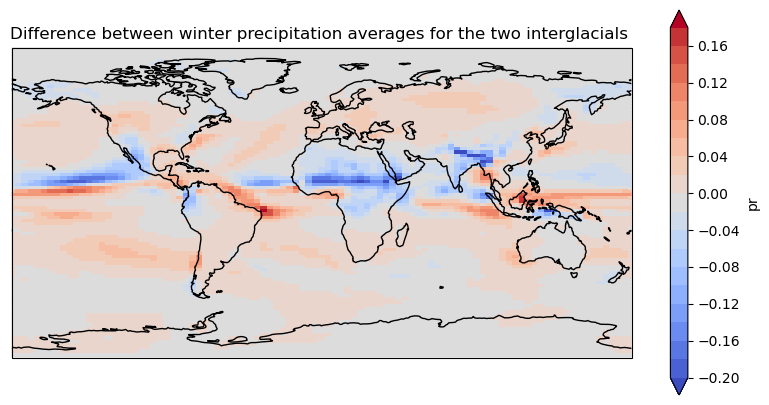

/Users/kellybaker/anaconda3/envs/envir_440/lib/python3.10/site-packages/xarray/core/missing.py:562: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
/Users/kellybaker/anaconda3/envs/envir_440/lib/python3.10/site-packages/xarray/core/missing.py:563: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)
/Users/kellybaker/anaconda3/envs/envir_440/lib/python3.10/site-packages/xarray/core/missing.py:562: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
/Users/kellybaker/anaconda3/envs/envir_440/lib/python3.10/site-packages/xarray/core/missing.py:563: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)


In [28]:
diff_model = calc_precip_holo - calc_precip_lig

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

diff_model.plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), levels=np.arange(-0.2, 0.2, 0.02), cbar_kwargs={'label': 'Precipitation (mm/h)'})

ax.coastlines()
ax.set_title("Difference between summer precipitation averages for the two interglacials ")

plt.show()

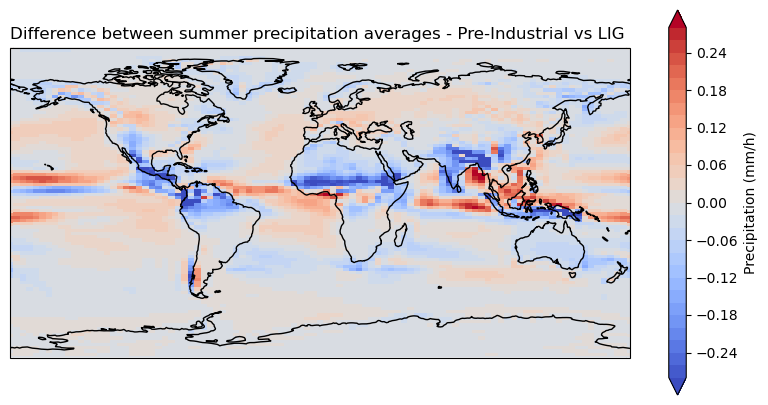

In [70]:
# to be regridded 

diff_model_pic_lig = calc_precip_now  - calc_precip_lig

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

diff_model_pic_lig.plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), levels=np.arange(-0.28, 0.28, 0.02), cbar_kwargs={'label': 'Precipitation (mm/h)'})

ax.coastlines()
ax.set_title("Difference between summer precipitation averages - Pre-Industrial vs LIG ")

plt.show()

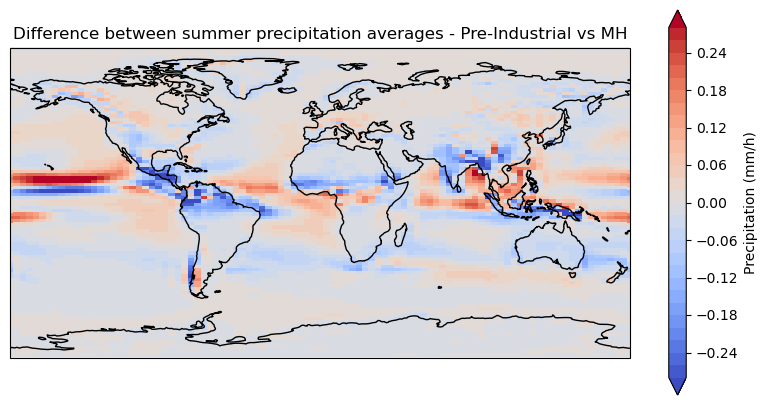

In [71]:
diff_model_pic_mh = calc_precip_now  - calc_precip_holo


plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

diff_model_pic_mh.plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), levels=np.arange(-0.28, 0.28, 0.02), cbar_kwargs={'label': 'Precipitation (mm/h)'})

ax.coastlines()
ax.set_title("Difference between summer precipitation averages - Pre-Industrial vs MH")

plt.show()

In [31]:
# definition for plotting production run time-averaged precipitation for given season

def plot_precipitation_season(dataset, title, month, start_year=-600, levels=np.arange(0, 1, 0.036)):
    # ignore ensemble and init year for now
    # specify start year (only production run) as an index
    data = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id')

    
    # Extract indices where time is the desired season, based on first month index of season (12 = winter, 3 = spring etc)
    indices = [i for i, t in enumerate(data.time.values) if t.month == month]
    
    # Select only desired season timstep
    data = data.isel(time=indices)
    
    # Average over this season
    mean = data.mean(dim='time')
    
    # Convert to mm/h using earlier function
    ga_mmh = convert_kg_m2s_to_mm_h(mean)

    # plot!
    plt.figure(figsize=(12, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ga_mmh.plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), levels=levels, cbar_kwargs={'label': 'Precipitation (mm/h)'})

    ax.coastlines()
    ax.set_title(f"{title}")

    plt.show()

In [32]:
#plot_precipitation_season(spr_holo, "Production Run of Precipitation in the Mid Holocene, Winter", 12)

In [33]:
#plot_precipitation_season(spr_holo, "Production Run of Precipitation in the Mid Holocene, Spring", 3)

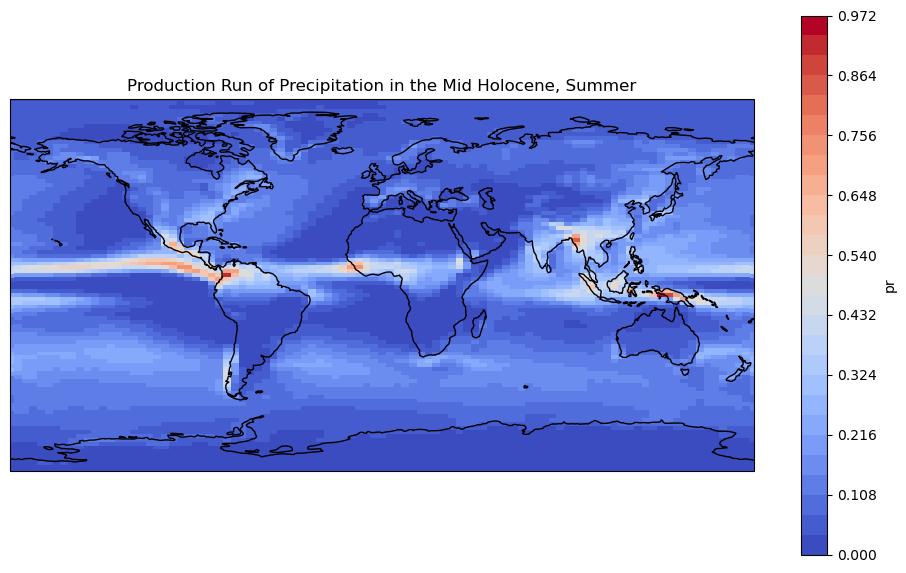

In [34]:
plot_precipitation_season(spr_holo, "Production Run of Precipitation in the Mid Holocene, Summer", 6)

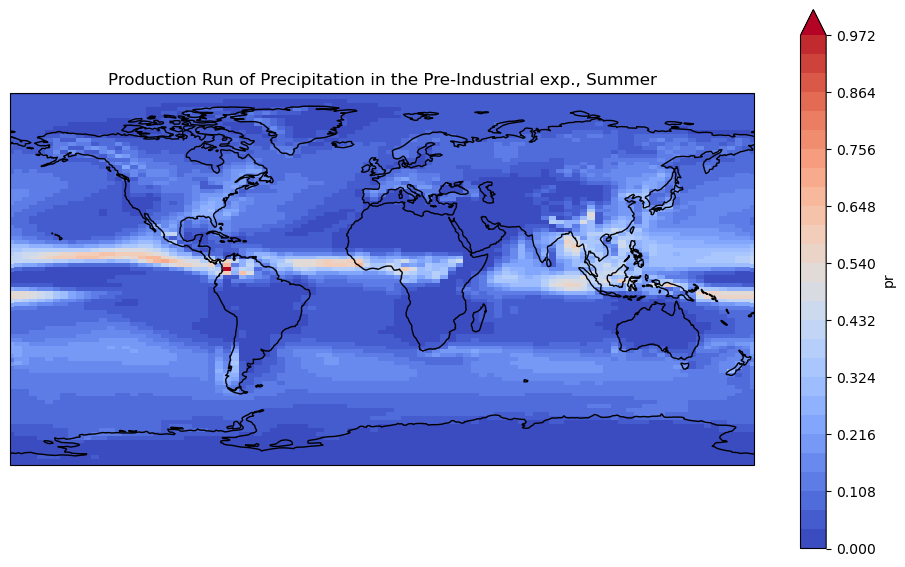

In [35]:
plot_precipitation_season(spr_now, "Production Run of Precipitation in the Pre-Industrial exp., Summer", 6)

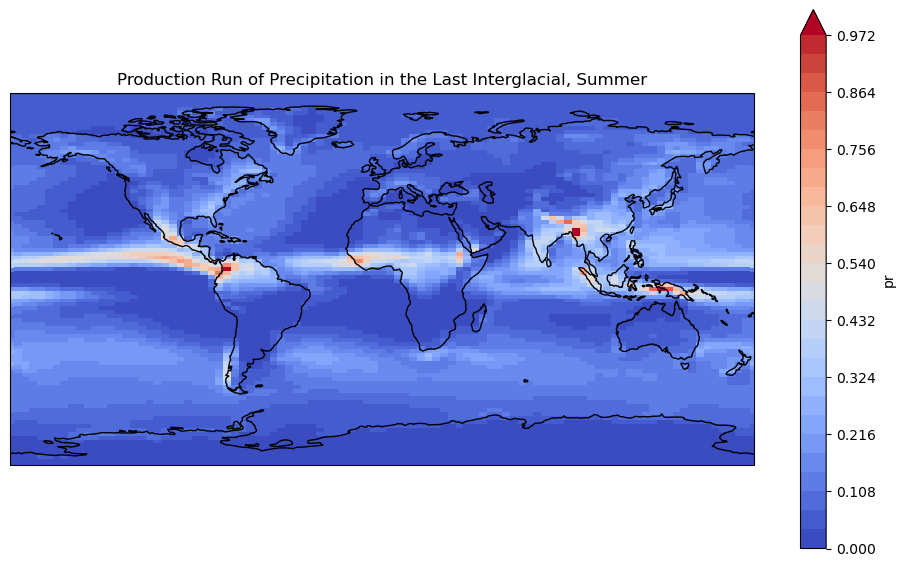

In [36]:
plot_precipitation_season(spr_lig, "Production Run of Precipitation in the Last Interglacial, Summer", 6)

### Visualise how artic amplification changes - standard deviation of the temperature over time

In [95]:
def plot_precipitation_season_std(dataset, title, month, start_year=-600, levels=np.arange(0, 0.5, 0.02)):
    """
    Plot the standard deviation of seasonal precipitation (in mm/h) over the production run period.

    Parameters:
    - dataset: xarray dataset with 'pr' (precipitation) variable, seasonal time steps (months: 12, 3, 6, 9)
    - title: title for the plot
    - month: first month of the season (e.g., 12 = DJF, 3 = MAM)
    - start_year: index to start the production run (default: -600 for the last 600 years)
    - levels: contour levels for plotting
    """

    # Subset to production run and mean over ensemble members
    data = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id')

    # Select only seasonal timesteps starting with the given month
    season_indices = [i for i, t in enumerate(data.time.values) if t.month == month]
    data = data.isel(time=season_indices)

    # Compute standard deviation over time (i.e., across all seasons of this type)
    std = data.std(dim='time')

    # Convert to mm/h
    ga_mmh_std = convert_kg_m2s_to_mm_h(std)

    # Plot
    plt.figure(figsize=(12, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ga_mmh_std.plot.pcolormesh(
        ax=ax,
        cmap='magma_r',
        transform=ccrs.PlateCarree(),
        levels=levels,
        cbar_kwargs={'label': 'Seasonal Precip Std Dev (mm/h)'}
    )

    ax.coastlines()
    ax.set_title(f"{title} — Std Dev of Seasonal Precipitation")
    plt.show()


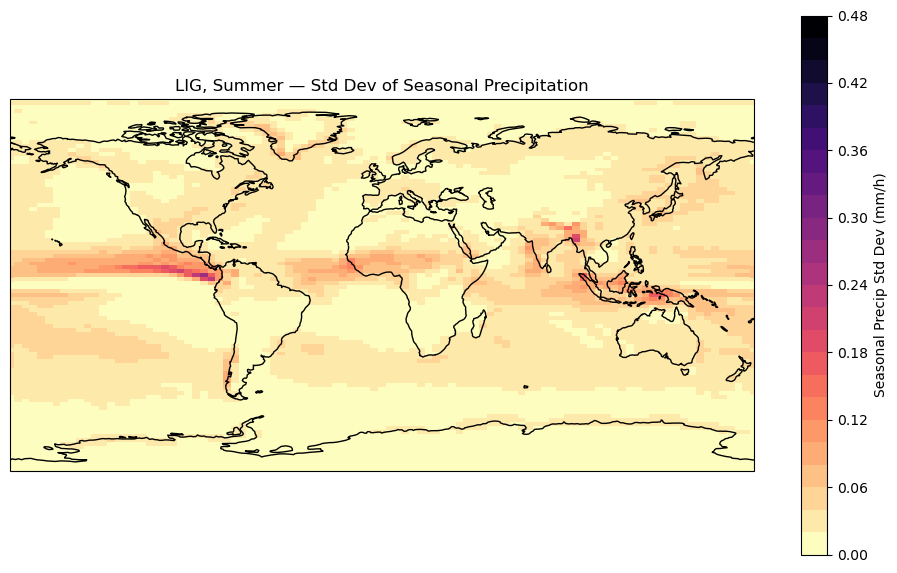

In [96]:
plot_precipitation_season_std(spr_lig, "LIG, Summer", 6)

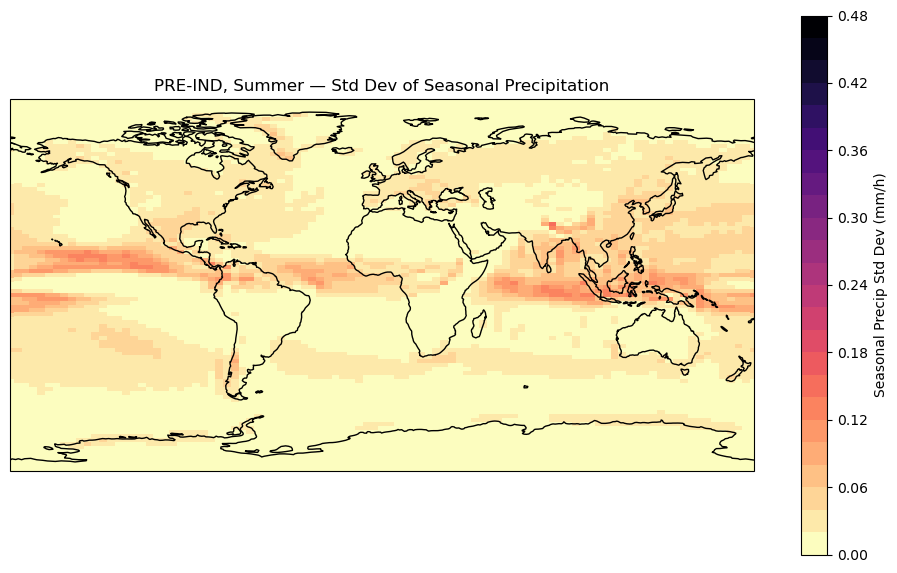

In [97]:
plot_precipitation_season_std(spr_now, "PRE-IND, Summer", 6)

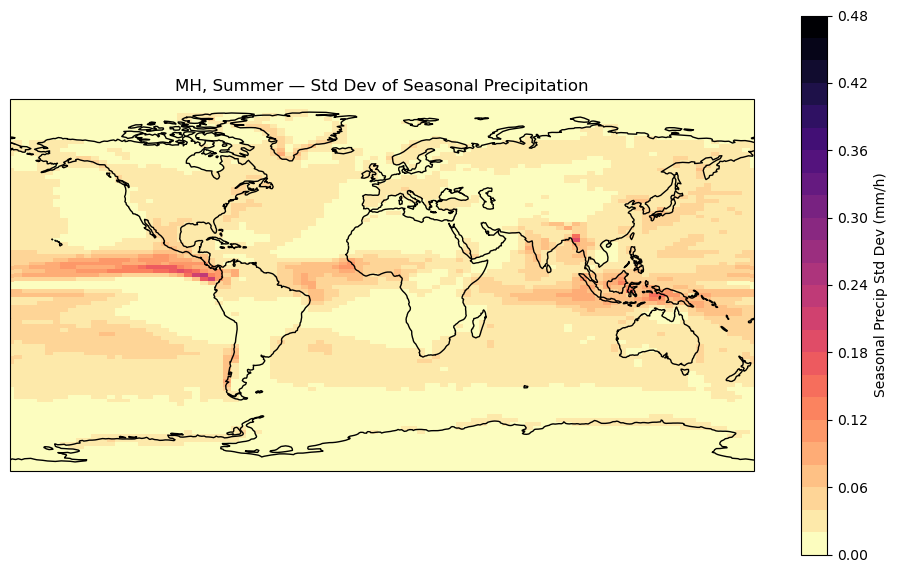

In [98]:
plot_precipitation_season_std(spr_holo, "MH, Summer", 6)

In [39]:
# rs_holo has other dimensions member_id: 3, dcpp_init_year: 1, so for the preliminary plots we average these too
# select last 200 time steps (i.e., last 50 years)
def time_series_global_precip(dataset, start_year):
    
    last50 = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id')
    
    # Compute global average (assuming 'lat' and 'lon' are coordinate names)
    global_avg = last50.mean(dim=['lat', 'lon'])
    
    ga_mmh = convert_kg_m2s_to_mm_h(global_avg)
    
    return ga_mmh

In [40]:
holo_ts_seasonal = time_series_global_precip(spr_holo, -40)
#ax1 = plot_timeseries('Global Average Seasonal Precipitation MidHolocene (mm/h) – production run', holo_ts_seasonal, 'blue')
holo_ts_monthly = time_series_global_precip(ds_holo.pr, -120)
#ax = plot_timeseries('Global Average Seasonal Precipitation MidHolocene (mm/h) – production run', holo_ts_monthly, 'orange', ax=ax1)


### Plots visualising how well seasonal averages capture the total precipitation pattern

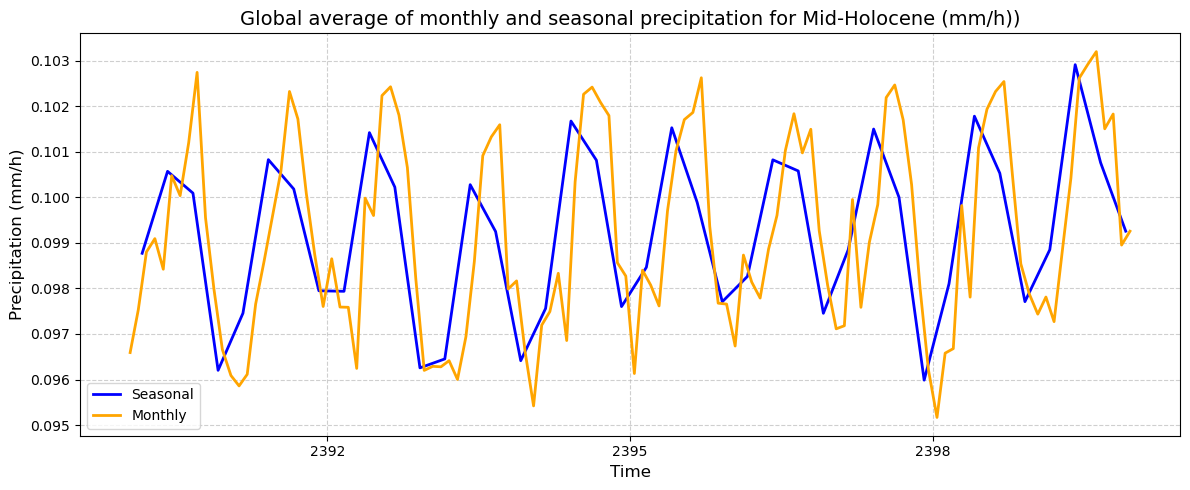

In [41]:
def dual_plot_timeseries(ds1, ds2, title):
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ds1.plot(ax=ax, color='blue', label='Seasonal', linewidth=2)
    ds2.plot(ax=ax, color='orange', label='Monthly', linewidth=2)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

dual_plot_timeseries(holo_ts_seasonal, holo_ts_monthly, "Global average of monthly and seasonal precipitation for Mid-Holocene (mm/h))")

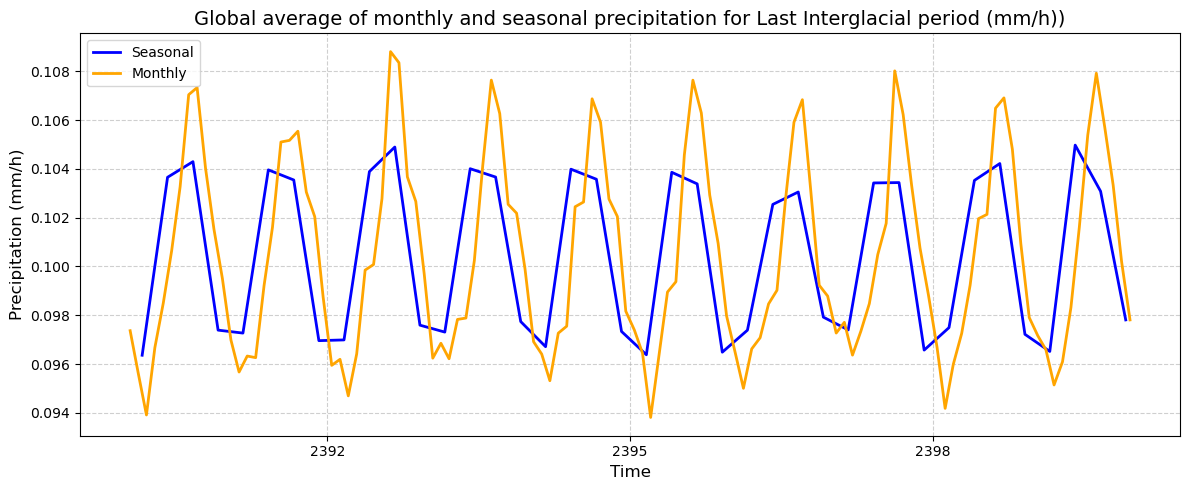

In [42]:
lig_ts_seasonal = time_series_global_precip(spr_lig, -40)
lig_ts_monthly = time_series_global_precip(ds_lig.pr, -120)
dual_plot_timeseries(lig_ts_seasonal, lig_ts_monthly, "Global average of monthly and seasonal precipitation for Last Interglacial period (mm/h))")


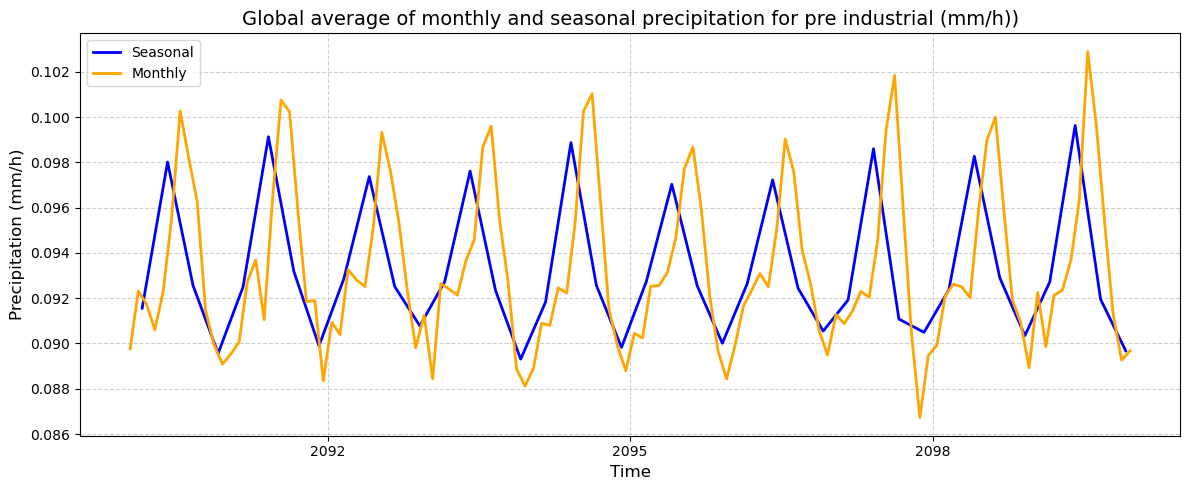

In [43]:
now_ts_seasonal = time_series_global_precip(spr_now, -40)
now_ts_monthly = time_series_global_precip(ds_now.pr, -120)
dual_plot_timeseries(now_ts_seasonal, now_ts_monthly, "Global average of monthly and seasonal precipitation for pre industrial (mm/h))")


### Plots for global average monthly precip patterns (comparison between models) - DONE

In [85]:
# create data slice by selecting precip + last 10 months + lat/lon mean

lig_glob = convert_kg_m2s_to_mm_h(ds_lig.pr.isel(time=slice(-120, None), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]))
holo_glob = convert_kg_m2s_to_mm_h(ds_holo.pr.isel(time=slice(-120, None), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]))
now_glob = convert_kg_m2s_to_mm_h(ds_now.pr.isel(time=slice(-120, None), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]))


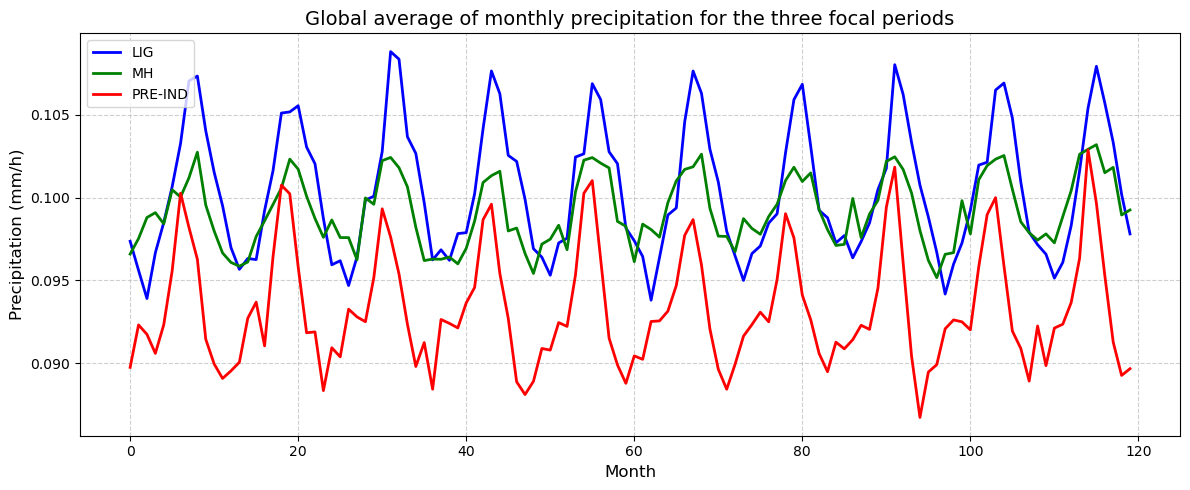

In [86]:
# instantiate a common time array for the two different actviities
common_time = np.arange(120)  # Months 0 to 119

# plot
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(common_time, lig_glob .values, color='blue', label='LIG', linewidth=2)
ax.plot(common_time, holo_glob.values, color='green', label='MH', linewidth=2)
ax.plot(common_time, now_glob.values, color='red', label='PRE-IND', linewidth=2)

ax.set_title("Global average of monthly precipitation for the three focal periods", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

### Plots for NH/SH average monthly precip patterns - DONE

In [87]:
# create data slice by selecting precip + last 10 months + lat slice + lat/long mean

lig_nh = convert_kg_m2s_to_mm_h(ds_lig.pr.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]))
holo_nh = convert_kg_m2s_to_mm_h(ds_holo.pr.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]))
now_nh = convert_kg_m2s_to_mm_h(ds_now.pr.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]))

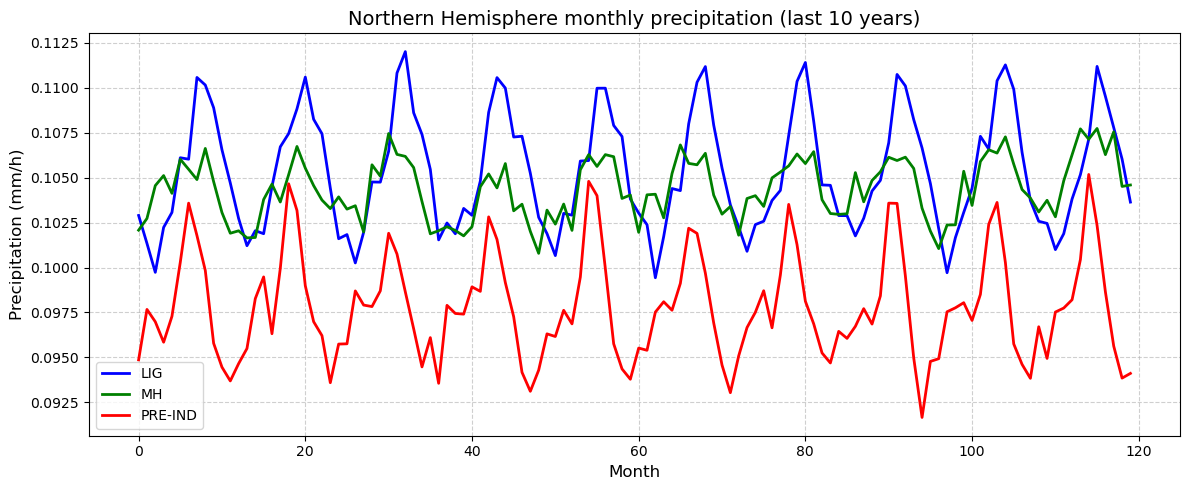

In [88]:
# instantiate a common time array for the two different actviities
common_time = np.arange(120)  # Months 0 to 119

# plot
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(common_time, lig_nh.values, color='blue', label='LIG', linewidth=2)
ax.plot(common_time, holo_nh.values, color='green', label='MH', linewidth=2)
ax.plot(common_time, now_nh.values, color='red', label='PRE-IND', linewidth=2)

ax.set_title( "Northern Hemisphere monthly precipitation (last 10 years)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()


### Ensemble member differences 

In [125]:
ds_holo

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 6600, lat: 96,
                     lon: 96, axis_nbounds: 2)
Coordinates:
  * time            (time) object 1850-01-16 12:00:00 ... 2399-12-16 12:00:00
  * dcpp_init_year  (dcpp_init_year) float64 nan
  * member_id       (member_id) object 'r1i1p1f1' 'r1i1p1f2' 'r1i1p1f3'
    time_bounds     (time, axis_nbounds) object dask.array<chunksize=(2400, 2), meta=np.ndarray>
  * lat             (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon             (lon) float32 0.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
Dimensions without coordinates: axis_nbounds
Data variables:
    pr              (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 600, 96, 96), meta=np.ndarray>
    ts              (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 800, 96, 96), meta=np.ndarray>
Attributes: (12/52)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            midHolocene
    activity_id:                      PMIP
    branch_method:                    no parent
    contact:                          ipsl-cmip6@listes.ipsl.fr
    ...                               ...
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20180926
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           PMIP.IPSL.IPSL-CM6A-LR.midHolocene.Amon.gr
    regrid_method:                    conservative

In [174]:
ds_holo

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 6600, lat: 96,
                     lon: 96, axis_nbounds: 2)
Coordinates:
  * time            (time) object 1850-01-16 12:00:00 ... 2399-12-16 12:00:00
  * dcpp_init_year  (dcpp_init_year) float64 nan
  * member_id       (member_id) object 'r1i1p1f1' 'r1i1p1f2' 'r1i1p1f3'
    time_bounds     (time, axis_nbounds) object dask.array<chunksize=(2400, 2), meta=np.ndarray>
  * lat             (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon             (lon) float32 0.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
Dimensions without coordinates: axis_nbounds
Data variables:
    pr              (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 600, 96, 96), meta=np.ndarray>
    ts              (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 800, 96, 96), meta=np.ndarray>
Attributes: (12/52)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            midHolocene
    activity_id:                      PMIP
    branch_method:                    no parent
    contact:                          ipsl-cmip6@listes.ipsl.fr
    ...                               ...
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20180926
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           PMIP.IPSL.IPSL-CM6A-LR.midHolocene.Amon.gr
    regrid_method:                    conservative

In [177]:
# looking at ensemble member differences

holo_nh_e1 = convert_kg_m2s_to_mm_h(ds_holo.pr.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0).sel(member_id = 'r1i1p1f1').mean(dim=["lat", "lon"]))
holo_nh_e2 = convert_kg_m2s_to_mm_h(ds_holo.pr.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0).sel(member_id = 'r1i1p1f2').mean(dim=["lat", "lon"]))
holo_nh_e3 = convert_kg_m2s_to_mm_h(ds_holo.pr.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0).sel(member_id = 'r1i1p1f3').mean(dim=["lat", "lon"]))
#now_nh1 = convert_kg_m2s_to_mm_h(ds_now.pr.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0, member_id = 0).mean(dim=["lat", "lon"]))
#now_nh2 = convert_kg_m2s_to_mm_h(ds_now.pr.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0, member_id = 1).mean(dim=["lat", "lon"]))
#now_nh3 = convert_kg_m2s_to_mm_h(ds_now.pr.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0, member_id = 2).mean(dim=["lat", "lon"]))

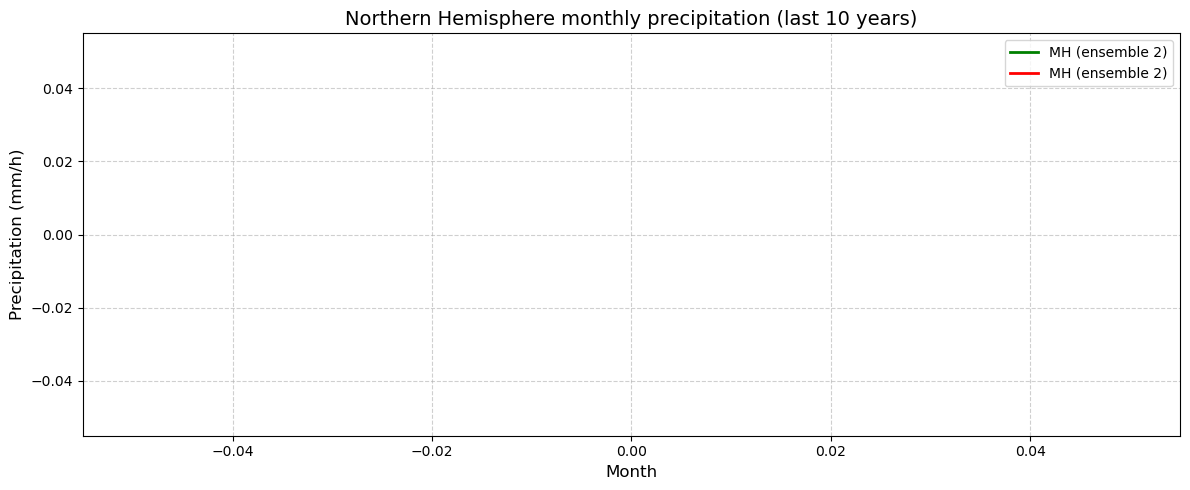

In [180]:
# instantiate a common time array for the two different actviities
common_time = np.arange(120)  # Months 0 to 119

# plot
fig, ax = plt.subplots(figsize=(12, 5))

#ax.plot(common_time, holo_nh_e1.values, color='blue', label='MH (ensemble 1)', linewidth=2)
ax.plot(common_time, holo_nh_e2.values, color='green', label='MH (ensemble 2)', linewidth=2)
ax.plot(common_time, holo_nh_e3.values, color='red', label='MH (ensemble 2)', linewidth=2)
#ax.plot(common_time, now_nh1.values, color='red', label='PRE-IND (ensemble 1)', linewidth=2)
#ax.plot(common_time, now_nh2.values, color='blue', label='PRE-IND (ensemble 2)', linewidth=2)
#ax.plot(common_time, now_nh3.values, color='green', label='PRE-IND (ensemble 3)', linewidth=2)
#
ax.set_title( "Northern Hemisphere monthly precipitation (last 10 years)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

### Calculate numerical differences differences between models at wet/dry seasons

In [90]:
def describe_precip_timeseries(ts, label):
    ts_np = ts.values  # convert to NumPy array if it's an xarray object

    # overall stats of the series
    mean_val = np.mean(ts_np)
    max_val = np.max(ts_np)
    min_val = np.min(ts_np)

    # reshape to (10 years, 12 months) and to allow to compute std of yearly means
    ts_reshaped = ts_np.reshape(10, 12)
    annual_means = ts_reshaped.mean(axis=1)
    annual_std = np.std(annual_means)

    # print results
    print(f"--- {label} ---")
    print(f"Mean: {mean_val:.3f} mm/h")
    print(f"Max: {max_val:.3f} mm/h")
    print(f"Min: {min_val:.3f} mm/h")
    print(f"Std Dev of Annual Means: {annual_std:.5f} mm/h\n")

describe_precip_timeseries(lig_nh, "Last Interglacial (LIG)")
describe_precip_timeseries(holo_nh, "Mid-Holocene (MH)")
describe_precip_timeseries(now_nh, "Pre-Industrial (PRE-IND)")


--- Last Interglacial (LIG) ---
Mean: 0.105 mm/h
Max: 0.112 mm/h
Min: 0.099 mm/h
Std Dev of Annual Means: 0.00017 mm/h

--- Mid-Holocene (MH) ---
Mean: 0.104 mm/h
Max: 0.108 mm/h
Min: 0.101 mm/h
Std Dev of Annual Means: 0.00055 mm/h

--- Pre-Industrial (PRE-IND) ---
Mean: 0.098 mm/h
Max: 0.105 mm/h
Min: 0.092 mm/h
Std Dev of Annual Means: 0.00017 mm/h



In [92]:
# same thing for just northern hemisphere precip

describe_precip_timeseries(lig_glob, "Last Interglacial (LIG)(NH)")
describe_precip_timeseries(holo_glob, "Mid-Holocene (MH)(NH)")
describe_precip_timeseries(now_glob, "Pre-Industrial (PRE-IND)(NH)")


--- Last Interglacial (LIG)(NH) ---
Mean: 0.100 mm/h
Max: 0.109 mm/h
Min: 0.094 mm/h
Std Dev of Annual Means: 0.00022 mm/h

--- Mid-Holocene (MH)(NH) ---
Mean: 0.099 mm/h
Max: 0.103 mm/h
Min: 0.095 mm/h
Std Dev of Annual Means: 0.00049 mm/h

--- Pre-Industrial (PRE-IND)(NH) ---
Mean: 0.093 mm/h
Max: 0.103 mm/h
Min: 0.087 mm/h
Std Dev of Annual Means: 0.00023 mm/h



### Plotting a longitude slice over the Northern American and Asian monsoons to compare experiments results

In [47]:
# function to plot preicp at a given lat slice

def plot_precipitation_fixed_lon(dataset, title, month, lon, start_year=-600):
    # ignore ensemble and init year for now
    # specify start year (only production run) as an index
    data = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).sel(lon=lon, method='nearest').mean(dim='member_id')
    
    # Extract indices where time is the desired season, based on first month index of season (12 = winter, 3 = spring etc)
    indices = [i for i, t in enumerate(data.time.values) if t.month == month]
    
    # Select only desired season timstep
    data = data.isel(time=indices)
    
    # Average over this season
    mean = data.mean(dim='time')
    
    # Convert to mm/h using earlier function
    ga_mmh = convert_kg_m2s_to_mm_h(mean)
    return ga_mmh


In [48]:
a = plot_precipitation_fixed_lon(spr_holo, "test", 6, -100,  start_year=-600)
b = plot_precipitation_fixed_lon(spr_lig, "test", 6, -100, start_year=-600)
c = plot_precipitation_fixed_lon(spr_now, "test", 6,-100, start_year=-600)

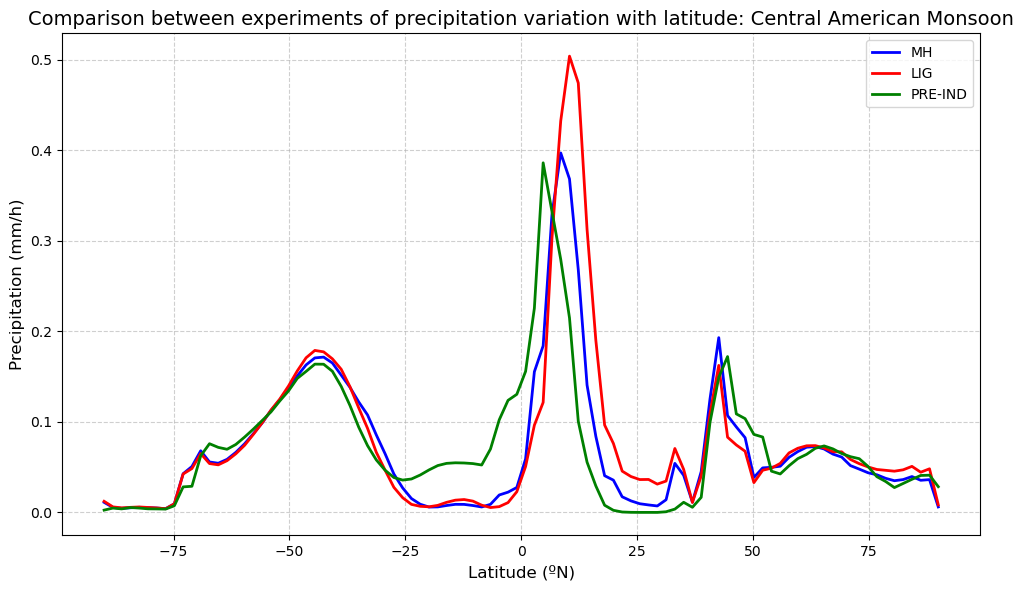

In [49]:

fig, ax = plt.subplots(figsize=(10, 6))
    
a.plot(ax=ax, color='blue', label='MH', linewidth=2)
b.plot(ax=ax, color='red', label='LIG', linewidth=2)
c.plot(ax=ax, color='green', label='PRE-IND', linewidth=2)
ax.set_title("Comparison between experiments of precipitation variation with latitude: Central American Monsoon", fontsize=14)
ax.set_xlabel("Latitude (ºN)", fontsize=12)
ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()


In [50]:
e = plot_precipitation_fixed_lon(spr_holo, "test", 6, 110,  start_year=-600)
f = plot_precipitation_fixed_lon(spr_lig, "test", 6, 110, start_year=-600)
g = plot_precipitation_fixed_lon(spr_now, "test", 6, 110, start_year=-600)

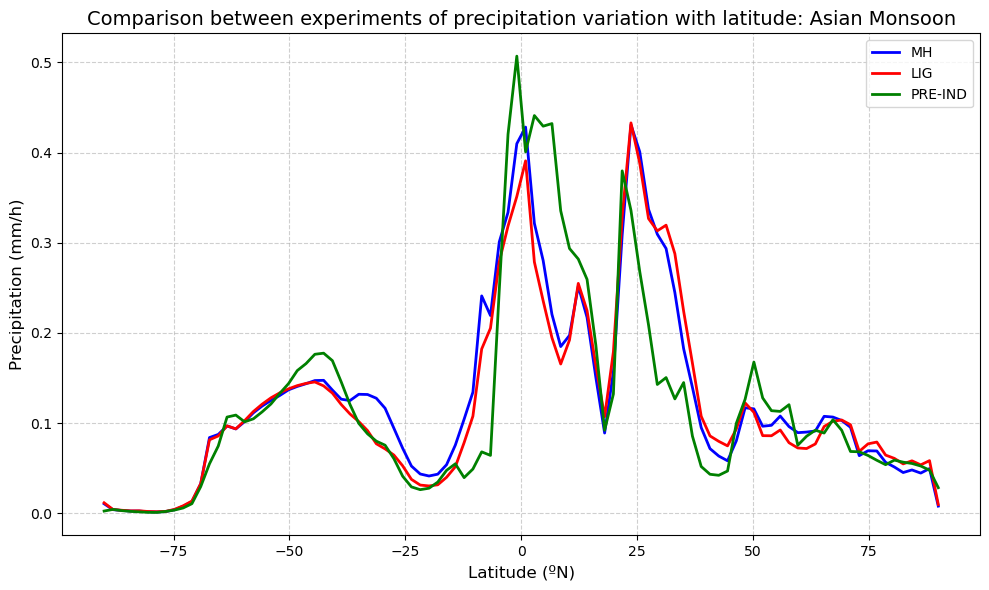

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
    
e.plot(ax=ax, color='blue', label='MH', linewidth=2)
f.plot(ax=ax, color='red', label='LIG', linewidth=2)
g.plot(ax=ax, color='green', label='PRE-IND', linewidth=2)
ax.set_title("Comparison between experiments of precipitation variation with latitude: Asian Monsoon", fontsize=14)
ax.set_xlabel("Latitude (ºN)", fontsize=12)
ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

# Temperature plots

In [52]:
sts_holo = ds_holo.ts.resample(time='QS-DEC').mean(dim='time') # extract pr variable 
sts_lig = ds_lig.ts.resample(time='QS-DEC').mean(dim='time')
sts_now = ds_now.ts.resample(time='QS-DEC').mean(dim='time')

In [99]:
def plot_temperature(dataset, title, start_year=-600):
    # ignore ensemble and init year for now
    # specify start year (only production run) as an index
    data = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id').sel(lat=slice(-89, 89))
    mean_temp = data.mean(dim='time')
    # plot!
    plt.figure(figsize=(12, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())

    mean_temp.plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Temperature (K)'})

    ax.coastlines()
    ax.set_title(f"{title}")

    plt.show()

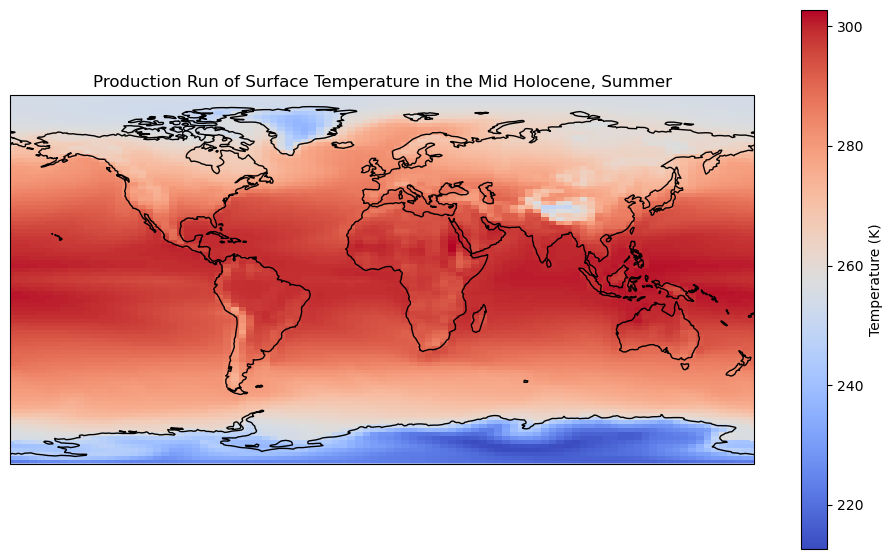

In [100]:
plot_temperature(sts_holo, "Production Run of Surface Temperature in the Mid Holocene, Summer", start_year=-600)

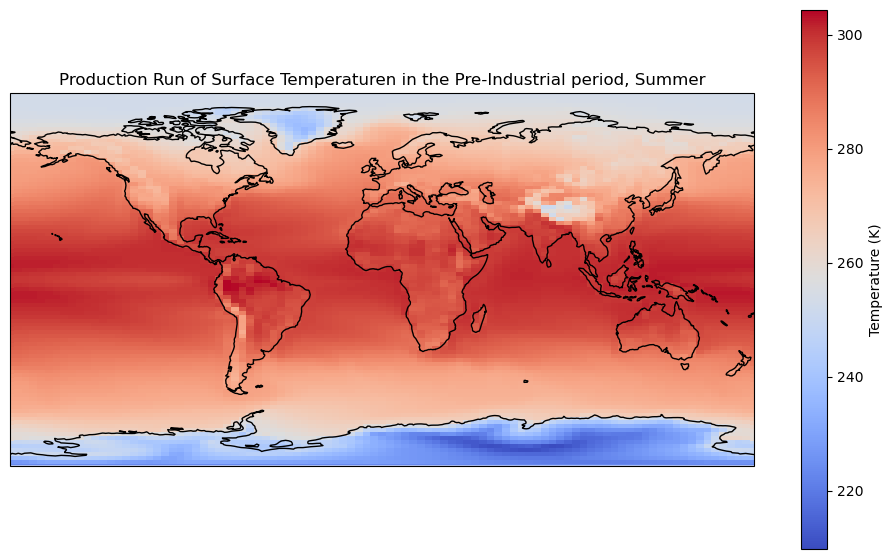

In [55]:
plot_temperature(sts_now, "Production Run of Surface Temperaturen in the Pre-Industrial period, Summer", start_year=-600)

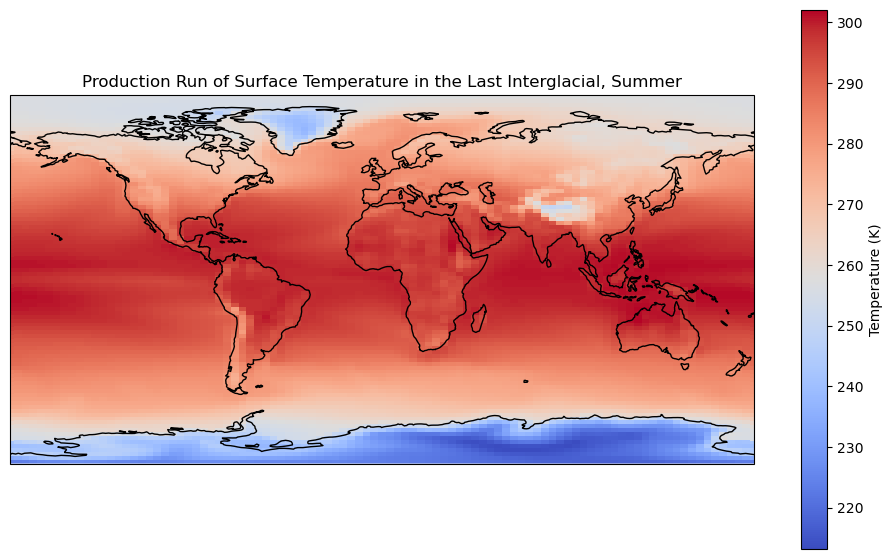

In [101]:
plot_temperature(sts_lig, "Production Run of Surface Temperature in the Last Interglacial, Summer", start_year=-600)

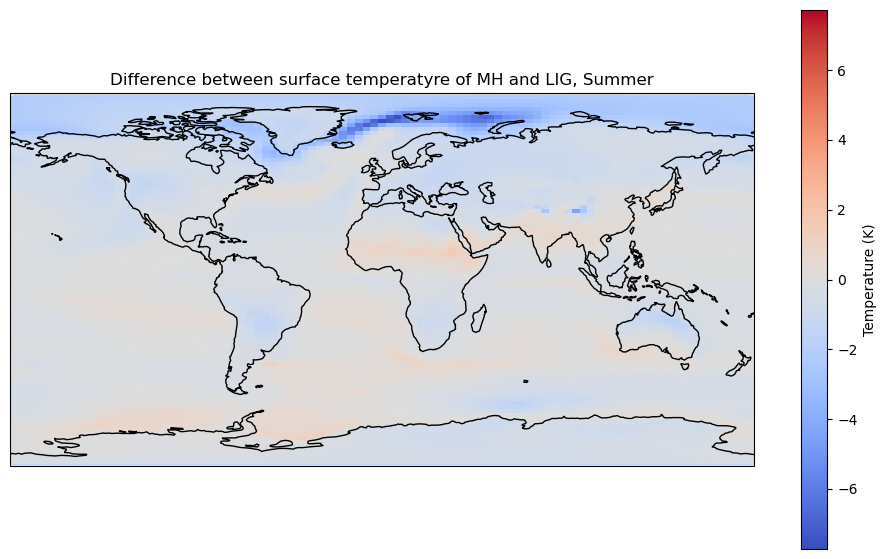

In [57]:
plot_temperature((sts_holo - sts_lig), "Difference between surface temperature of MH and LIG, Summer", start_year=-600)

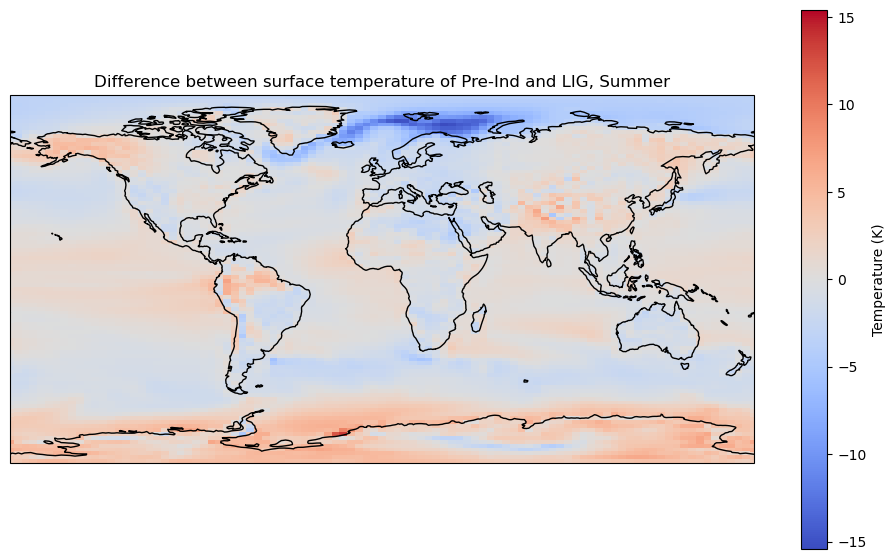

In [112]:
def plot_temperature_dual(dataset1, dataset2, title, start_year=-600):
    # ignore ensemble and init year for now
    # specify start year (only production run) as an index
    data1 = dataset1.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id').sel(lat=slice(-89, 89))
    data2 = dataset2.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id').sel(lat=slice(-89, 89))
    now_aligned = data1.assign_coords(time=data2.time)
    
    mean_temp1 = now_aligned.mean(dim='time')
    mean_temp2 = data2.mean(dim='time')
    # plot!
    plt.figure(figsize=(12, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())

    (mean_temp1-mean_temp2).plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Temperature (K)'})

    ax.coastlines()
    ax.set_title(f"{title}")

    plt.show()


plot_temperature_dual(sts_now, sts_lig, "Difference between surface temperature of Pre-Ind and LIG, Summer", start_year=-600)

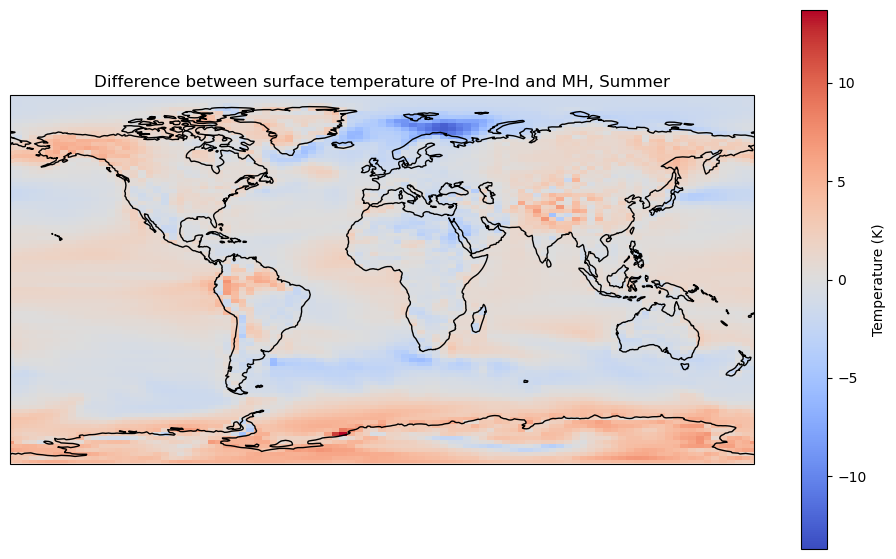

In [115]:
plot_temperature_dual(sts_now, sts_holo, "Difference between surface temperature of Pre-Ind and MH, Summer", start_year=-600)

## Plot latitude temperature variation

In [61]:
def plot_temp_over_lats(dataset, title, month, lon, start_year=-600):
    # Take mean over ensemble and select closest longitude
    data = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).sel(lon=lon, method='nearest').mean(dim='member_id')
    
    # Filter time steps to the desired month (e.g. June for summer)
    indices = [i for i, t in enumerate(data.time.values) if t.month == month]
    data = data.isel(time=indices)
    
    # Average over time (seasonal mean)
    mean = data.mean(dim='time')
    
    # Limit to Northern Hemisphere only
    mean_nh = mean.sel(lat=slice(0, 89))

    return mean_nh
 

In [62]:
nh_mh = plot_temp_over_lats(sts_holo, "Test", 6, -90, start_year=-600)
nh_lig = plot_temp_over_lats(sts_lig, "Test", 6, -90, start_year=-600)
nh_now = plot_temp_over_lats(sts_now, "Test", 6, -90, start_year=-600)

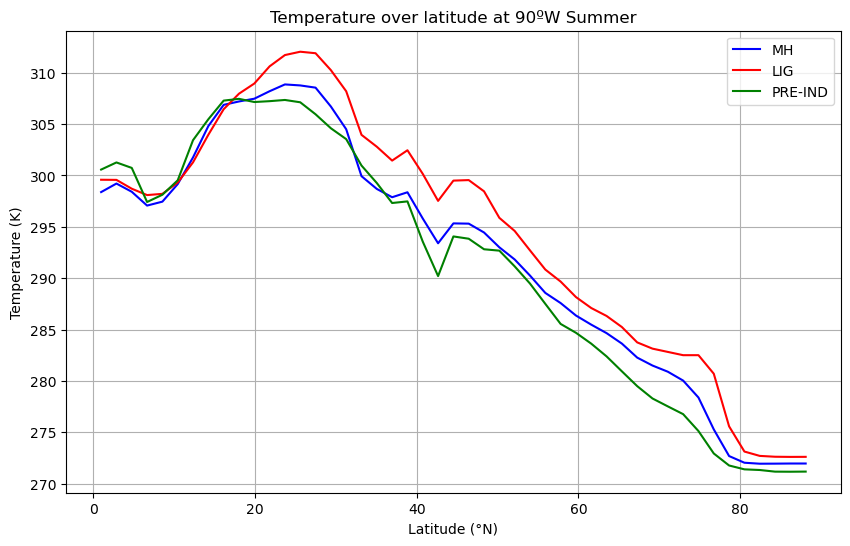

In [63]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(nh_mh.lat, nh_mh.values, color='blue', label='MH' )
plt.plot(nh_lig.lat, nh_lig.values, color='red', label='LIG')
plt.plot(nh_now.lat, nh_now.values, color='green', label='PRE-IND')
plt.xlabel("Latitude (°N)")
plt.ylabel("Temperature (K)")
plt.title("Temperature over latitude at 90ºW Summer")
plt.legend()
plt.grid(True)
plt.show()


### Model comparison for the MH and Pre-Ind